In [1]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import numpy as np

<h1>Data Cleaning</h1>

In [2]:
df = pd.read_csv('Books.csv')

/tmp/ipykernel_36641/1598234465.py:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('Books.csv')


In [3]:
df.columns

Index(['ISBN', 'Book-Title', 'Book-Author', 'Year-Of-Publication', 'Publisher',
       'Image-URL-S', 'Image-URL-M', 'Image-URL-L'],
      dtype='object')

In [4]:
df.drop(['Image-URL-S', 'Image-URL-M', 'Image-URL-L'], axis=1, inplace=True)

In [5]:
df.columns

Index(['ISBN', 'Book-Title', 'Book-Author', 'Year-Of-Publication',
       'Publisher'],
      dtype='object')

Check for nulls

In [6]:
df.isnull().sum()

ISBN                   0
Book-Title             0
Book-Author            2
Year-Of-Publication    0
Publisher              2
dtype: int64

In [7]:
df.dropna(inplace=True)

In [8]:
df.isnull().sum()

ISBN                   0
Book-Title             0
Book-Author            0
Year-Of-Publication    0
Publisher              0
dtype: int64

Make sure there are no duplicate ISBNs

In [9]:
len(df['ISBN'].unique()) <= len(df['Book-Title']) #we can have duplicate titles, but need to have different ISBNs

True

In [10]:
len(df['ISBN'].unique()) == len(df['ISBN']) #make sure no duplicate ISBNs

True

In [11]:
len(df['Book-Title'].unique()) == len(df['Book-Title']) #check for duplicate titles (which isn't a problem)

False

Looks like there ARE duplicate titles; which means using title to extract content-based data won't be super helpful.

<h1>Finding Book "Classes"</h1>

Book titles can be very uninformative of a book's content. For example, Harry Potter and Sherlock Holmes are both books whose titles are the protagonists' names. However, their content is very different: one is about magic, the other is about crime and detective work. We believe that using the author, the publisher, and the publication year will prove to be better indicators of a book's content. We think this for the following reasons:  
- authors tend to specify on certain genres
- publishers tend to focus on certain genres
- the year can be an additional factor to help determine the "current focus" of an author and publisher in a given year

In [12]:
df['Book-Author'] = df['Book-Author'].apply(lambda x: str(x)) #apparently there are some float-type values
authors = [x.strip(' ') for x in df['Book-Author']]
authors[:5]

['Mark P. O. Morford',
 'Richard Bruce Wright',
 "Carlo D'Este",
 'Gina Bari Kolata',
 'E. J. W. Barber']

In [13]:
#regularize author names
for i in range(len(authors)):
    a = authors[i]
    a = a.lower()
    new = ''
    for l in a:
        if ord(l) in range(97, 123):
            new += l
    authors[i] = (new)
    
authors[:5]        

['markpomorford',
 'richardbrucewright',
 'carlodeste',
 'ginabarikolata',
 'ejwbarber']

In [14]:
# do the same thing for publishers
df['Publisher'] = df['Publisher'].apply(lambda x: str(x))
df['Publisher'] = df['Publisher'].apply(lambda x: x.replace('&amp;', 'and'))
publishers = [x.strip(' ') for x in df['Publisher']]
publishers[:5]

['Oxford University Press',
 'HarperFlamingo Canada',
 'HarperPerennial',
 'Farrar Straus Giroux',
 'W. W. Norton and Company']

In [15]:
#regularize publisher names
for i in range(len(publishers)):
    p = publishers[i]
    p = p.lower()
    new = ''
    for l in p:
        if ord(l) in range(97, 123):
            new += (l)
    publishers[i] = (new)
    
publishers[:5]

['oxforduniversitypress',
 'harperflamingocanada',
 'harperperennial',
 'farrarstrausgiroux',
 'wwnortonandcompany']

In [16]:
years = []
for y in df['Year-Of-Publication']:
    if type(y) == int:
        years.append(y)
    else:
        years.append(0)
years[:5]

[2002, 2001, 1991, 1999, 1999]

In [17]:
content = []
for i in range(len(authors)):
    content.append( authors[i] + ' ' + publishers[i] + ' ' + str(years[i]) )
content[:5]

['markpomorford oxforduniversitypress 2002',
 'richardbrucewright harperflamingocanada 2001',
 'carlodeste harperperennial 1991',
 'ginabarikolata farrarstrausgiroux 1999',
 'ejwbarber wwnortonandcompany 1999']

In [18]:
t = TfidfVectorizer(max_features=1000)
x = t.fit_transform(content)

In [19]:
df_x = pd.DataFrame(x.todense())

In [20]:
pca = PCA(n_components=2)
content_reduced = pca.fit_transform(df_x)

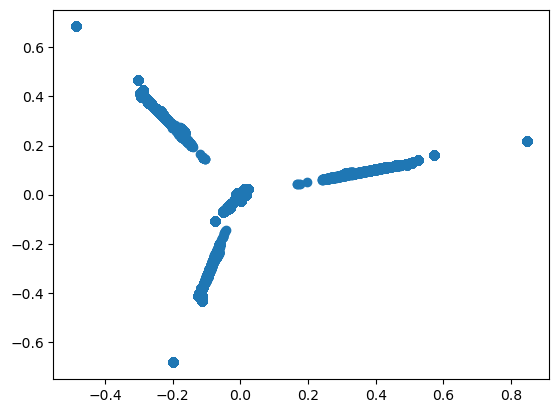

In [21]:
plt.scatter(content_reduced[:,0], content_reduced[:,1])

Since we don't know AT ALL how many clusters/classes there might be, we need to use a graph to get a rough number of clusters. Using DBSCAN is an option, but it will classify certain books as noise points, which won't help at all in our recommender system/

In [22]:
# taking a sample because computer can't use entire data
sample_size = 10000
df_x_sample = df_x[:sample_size]
reduced_sample = content_reduced[:sample_size]

In [23]:
wcss = [] #collect SSE for different models
kmeans = None

#collect SSE for k=1 to k=99
for i in range(1,100):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(df_x_sample)
    
    sum_ = 0
    for j in range(len(df_x_sample)):
        index = kmeans.labels_[j]
        centroid = kmeans.cluster_centers_[index]
        point = df_x_sample.iloc[j]
        sum_ += np.sum((point - centroid)**2)
            
    wcss.append(sum_)

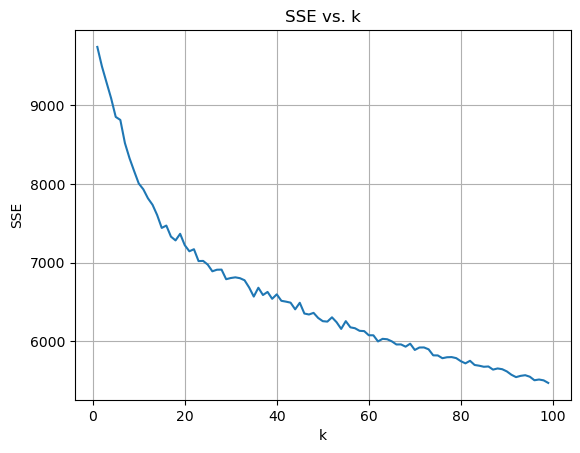

In [24]:
#plot SSE vs. k
plt.plot(np.arange(1,100), wcss)
plt.title('SSE vs. k')
plt.xlabel('k')
plt.ylabel('SSE')
plt.grid()

Looks like the SSE starts evening out right before k=20. Let's focus on that region to get a better look.

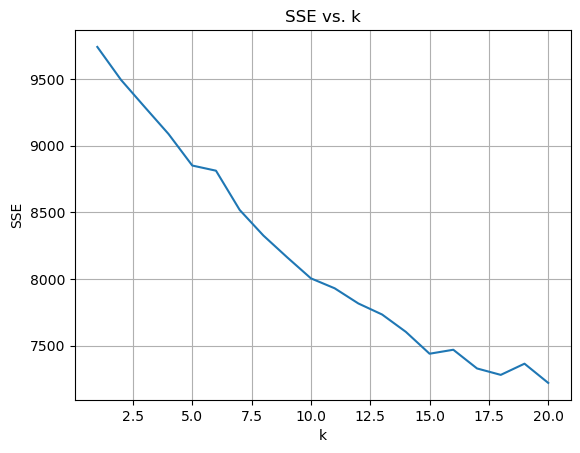

In [25]:
#plot SSE vs. k
plt.plot(np.arange(1,21), wcss[:20])
plt.title('SSE vs. k')
plt.xlabel('k')
plt.ylabel('SSE')
plt.grid()

The graph is indicating that the SSE starts to even out at around k=15. So, that's the number of clusters we'll use.

In [26]:
#train k=3 KMeans model
kmeans = KMeans(n_clusters=15, init='k-means++', max_iter=300, n_init=10, random_state=0)
kmeans.fit(df_x_sample)

KMeans(n_clusters=15, n_init=10, random_state=0)

Text(0.5, 1.0, 'k=15 KMeans clustering')

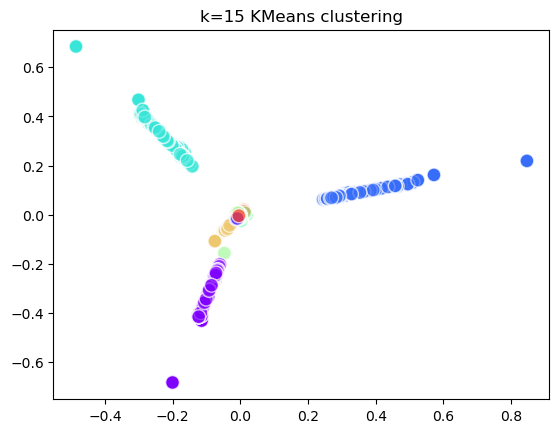

In [27]:
#visualize clusters
plt.scatter(reduced_sample[:,0], reduced_sample[:,1], c=kmeans.labels_, cmap='rainbow', alpha=0.7, edgecolors='w', s=100)
plt.title('k=15 KMeans clustering')

In [28]:
clusters = np.unique(kmeans.labels_)

Text(0.5, 1.0, 'Cluster Sizes for k=15')

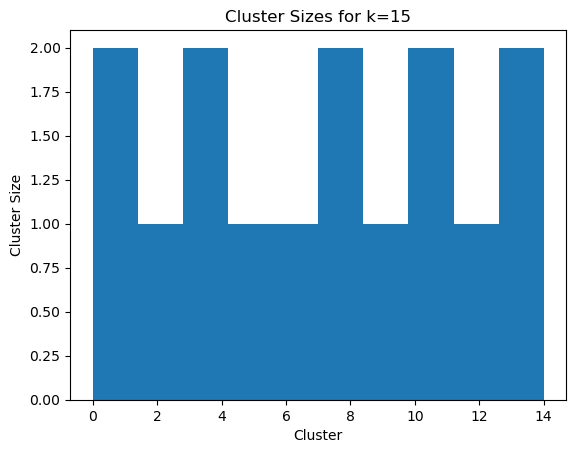

In [29]:
plt.hist(clusters)
plt.xlabel('Cluster')
plt.ylabel('Cluster Size')
plt.title('Cluster Sizes for k=15')

Looks like none of the clusters are useless, since none of them have a disproportionately small amount of books. Also, if any clusters had a disproportionately high amount of books, that would have been a problem as well. Looks like 15 clusters is a good choice for the data we are using.

<h1>Classifying the books</h1>

Now that we have classes for the sampled books, all that's left is to create a new dataframe with ISBN and the centroids of the clusters. The idea is that 2 books whose cluster centroids are closer together should have similar content compared to 2 books whose cluster centroids are farther away.

In [30]:
centroids = [kmeans.cluster_centers_[i] for i in kmeans.labels_]
isbns = df['ISBN'][:sample_size]

In [31]:
classified = pd.DataFrame(centroids)
classified['ISBN'] = isbns
classified.head()

,0,1,2,3,4,5,6,7,8,9,...,991,992,993,994,995,996,997,998,999,ISBN
0,1.084202e-18,-6.234162e-19,-3.523657e-19,3.252607e-19,1.301043e-18,-2.168404e-19,2.005774e-18,-8.673617e-19,4.119968e-18,-5.963112e-19,...,6.938894e-18,9.829566e-04,-6.234162e-19,9.800774e-04,1.235990e-17,0.0,0.003330,1.734723e-18,2.059984e-18,0195153448
1,9.757820e-19,-3.388132e-19,-3.523657e-19,1.409463e-18,-1.626303e-19,-2.168404e-19,1.951564e-18,-8.673617e-19,3.144186e-18,-5.014435e-19,...,4.865811e-03,2.215379e-03,-6.098637e-19,7.760145e-04,7.156626e-04,0.0,0.003675,-9.757820e-19,1.087958e-03,0002005018
2,-4.336809e-19,2.303930e-19,-3.252607e-19,-9.215718e-19,-7.047314e-19,-2.168404e-19,5.421011e-19,-6.505213e-19,-1.192622e-18,2.710505e-19,...,2.765621e-03,5.421011e-20,-2.710505e-19,3.686287e-18,-2.385245e-18,0.0,0.000000,-1.192622e-18,1.951564e-18,0060973129
3,8.673617e-19,-5.421011e-20,-3.252607e-19,1.301043e-18,-2.710505e-19,-2.168404e-19,1.843144e-18,-8.673617e-19,2.168404e-18,-3.930233e-19,...,5.859424e-03,1.246832e-18,-5.827587e-19,8.614151e-04,1.994720e-03,0.0,0.005348,1.235645e-03,1.218197e-03,0374157065
4,8.673617e-19,-5.421011e-20,-3.252607e-19,1.301043e-18,-2.710505e-19,-2.168404e-19,1.843144e-18,-8.673617e-19,2.168404e-18,-3.930233e-19,...,5.859424e-03,1.246832e-18,-5.827587e-19,8.614151e-04,1.994720e-03,0.0,0.005348,1.235645e-03,1.218197e-03,0393045218


classified.to_csv('books_classified.csv')